# Resource vs Utility

Given an application, the latency (utility) of all clients depends on:
  * amount of resources allocated (system determined)
    * how well the application is able to use the allocated resources (OMP_NUM_THREAD): (app determined)
  * number of total clients served by the application (system determined)

The amount of resources allocated consists of the number of cores (**height**) and the amount of cpu shares per core (**width**). The total cpu resources is # cores * cpu shares per core (**area**). If we think of the total amount of cpu resources as a rectangle. The resource allocation carves a shape (a smaller square/rectangle) out of the rectangle. Both the shape and the area of the carved piece matter to applications. For example, an ideal parallizable app has similar utility for a fixed area regardless of the shape. On the other hand, a single thread application, can only take advantages of a smaller rectangle out of a square. Unfortunately, in our set-up, we only have control over the width (cpu shares per core), not the height.

In our setup, we can find the cpu share and the client number that maximize utility.
  * Consider an ideally parallizable job. The more cpu shares we give it, the better the utility (until the total amount of cpu resources becomes larger than the workload). Hence, we want to find the lowest cpu share number that achieves max utility.
  * Now consider an non-ideally parallizable job, which is mostly single-core. It behaves the same as the parallizable job. The more cpu shares we give it, the better the utility (until the total amount of cpu resources becomes larger than the workload).



* Eventually, we want a curve of resource vs utility
* We can get intermediate resource vs latency curve
* multiple ways to convert latency to utility
  * find the average of frame utility
  * take the 90th percentile of frame utility
  
## Optimization problem formulation

* max sum of u(c,m) subject to sum c <= c_total, sum m <= m_total
* the utility function may not be convex, therefore not able to solve it efficiently in polynomial time
* use iterative random search or gradient descent to find local optimal

In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

from rmexp import dbutils, schema
#from rmexp.utilityfunc import app_default_utility_func

In [2]:
import scipy

def create_latency_sigmoid(lo_x, hi_x, lo_y=0.9, hi_y=0.99):
    # y = 1 / (1 + exp^(ax-b))
    # => xa - b = ln(1/y - 1)
    a, b = np.linalg.solve([[lo_x, -1], [hi_x, -1]],
                           np.log([1./lo_y - 1, 1./hi_y - 1]))
    return lambda x: 1. / (1. + np.exp(a*x - b))

def get_slow_exponential(slow_decay_st, expo_decay_st, half_life):
    slow_decay_st, expo_decay_st, half_life = map(float, 
                                                  [slow_decay_st, expo_decay_st, half_life])
    exponential_lambda = np.log(2.) / half_life
    # 1 - (x/a)^n
    slow_n = 4.0
    slow_a = (expo_decay_st - slow_decay_st) / np.power(1 - 0.9, 1 / slow_n)
    def util_one(x):
        if x <= slow_decay_st:
            return 1.0
        elif x > slow_decay_st and x <= expo_decay_st:
            return 1 - np.power( (x-slow_decay_st) / slow_a, 4)
        else:
            # exponential decay
            return 0.9 * np.exp(-exponential_lambda * (x-expo_decay_st))
    return util_one

lego_util = get_slow_exponential(600, 2700, (2700-600)/4.0)   

# Based on Zhuo's SEC'17
app_default_utility_func = {
    'lego':  get_slow_exponential(600, 2700, (2700-600)/4.0),
    'pingpong': get_slow_exponential(150, 230, (230-150)/8.0), # decay twice faster
    'pool': get_slow_exponential(95, 105, (105-95)/4.0),
    'face': get_slow_exponential(370, 1000, (1000-370)/4.0),    
#    'face': create_latency_sigmoid(370, 1000),
}

<IPython.core.display.Javascript object>


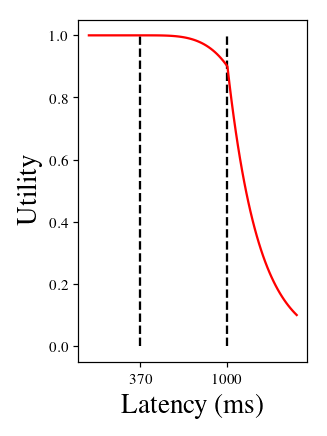

/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<IPython.core.display.Javascript object>


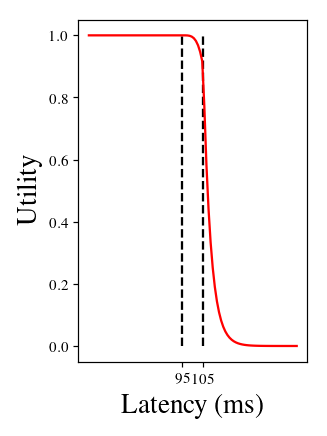

In [3]:
%matplotlib notebook

x = np.linspace(0, 1500, 100)
plt.figure(figsize=(3,4))
plt.plot(x, map(app_default_utility_func['face'], x), 'r-')
plt.vlines([370, 1000], 0., 1., linestyles='dashed')
plt.xticks([370, 1000])
plt.xlabel('Latency (ms)', fontsize=18)
plt.ylabel('Utility', fontsize=18)
plt.tight_layout()
plt.savefig('fig-lat-util-%s.pdf' % 'face', bbox_inches='tight')

x = np.linspace(50, 150, 100)
plt.figure(figsize=(3,4))
plt.plot(x, map(app_default_utility_func['pool'], x), 'r-')
plt.vlines([95, 105], 0., 1., linestyles='dashed')
plt.xticks([95, 105])
plt.xlabel('Latency (ms)', fontsize=18)
plt.ylabel('Utility', fontsize=18)
plt.tight_layout()
plt.savefig('fig-lat-util-%s.pdf' % 'pool', bbox_inches='tight')

In [176]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate
import cPickle as pickle
import collections
import math

class ResourceToLatency(object):
    def __init__(self, app, exp_name, l2u_func=None):
        self.app = app
        self.exp_name = exp_name
        self.l2u_func = l2u_func
        self._df = self._get_df_by_latency()
        self.func = None
    
    def _get_df_by_latency(self):
        """Get dataframe by converting latency to utility frame by frame"""
        df = pd.read_sql(
            "select latency, cpu, memory, num_worker from ResourceLatency where name=%(exp_name)s and trace like %(app)s",
            schema.engine,
             params={'app': self.app+'%', 'exp_name': self.exp_name}
        )
        if self.l2u_func is not None:
            df['util'] = df['num_worker'] * (df['latency'].apply(self.l2u_func))
        return df
        
    def __call__(self, cpu, **kwargs):
        return self.predict_cpu(cpu)
        
    def print_profile(self):
        print(self._df)
        
    def plot_cpu(self, plt, memory=2, fmt='o'):
        plt.plot('cpu', 'mean_latency', fmt, data=self._df[self._df['memory']==2], label=self.app)
    
    def smooth_to_non_decreasing(self, cpus, mems, utils, max_cpu, max_mem):
        vals = {}
        for idx, _ in enumerate(cpus):
            vals[(cpus[idx], mems[idx])] = utils[idx]
        cpus_sorted = sorted(list(set(cpus)))
        mems_sorted = sorted(list(set(mems)))
        result = []
        for cidx, cpu in enumerate(cpus_sorted):
            for midx, mem in enumerate(mems_sorted):
                candidates = set([(cpu, mem),(cpus_sorted[cidx - 1], mem), 
                                 (cpu, mems_sorted[midx - 1]),
                                 (cpus_sorted[cidx - 1], mems_sorted[midx - 1])])
                exception = set()
                if cidx == 0:
                    exception.add((cpus_sorted[cidx - 1], mem))
                    exception.add((cpus_sorted[cidx - 1], mems_sorted[midx - 1]))
                if midx == 0:
                    exception.add((cpu, mems_sorted[midx - 1]))
                candidate_vals = map(lambda x: vals[x] if x in vals else 0, (candidates - exception))
                non_decreasing_val = max(candidate_vals)
                
                #if (cpu, mem) in vals:
                result.append((cpu, mem, non_decreasing_val))
                vals[(cpu, mem)] = non_decreasing_val
        
        max_cpu_ceil = int(math.floor(max(cpus) + 1))
        max_mem_ceil = int(math.floor(max(mems) + 1))
        # add in extra cpu
        for extra_cpu in range(max_cpu_ceil, max_cpu):
            for mem in mems_sorted:
                result.append((extra_cpu, mem, vals[(max(cpus), mem)]))
        
        # add in extra mem
        for extra_mem in range(max_mem_ceil + 1, max_mem):
            for cpu in cpus_sorted:
                result.append((cpu, extra_mem, vals[(cpu, max(mems))]))

        # add in region where both cpu and mem are extra
        for extra_cpu in range(max_cpu_ceil, max_cpu):
            for extra_mem in range(max_mem_ceil, max_mem):
                result.append((extra_cpu, extra_mem, vals[(max(cpus), max(mems))]))                
        return zip(*result)
    
    def plot_util(self):
        groups = self._df.groupby(['cpu', 'memory'])
        cpus = np.array([name[0] for name, _ in groups])
        mems = np.array([name[1] for name, _ in groups])
        print('calculating per second util by each_util * avg_fps')
        util_avgs = np.array([group['util'].mean() * (1000. / group['latency'].mean()) for _, group in groups])
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter(cpus, mems, util_avgs, c='k')
        ax.set_xlabel('CPUs', fontsize=18)
        ax.set_ylabel('Memory', fontsize=18)
        ax.set_zlabel('Avg Utility', fontsize=18)
        for (x, y, z) in zip(cpus, mems, util_avgs):
            pt_txt = '{}'.format((round(x, 2), round(y, 2),round(z, 2)))
        print('{} Profile'.format(self.app))

        cpus, mems, util_avgs = self.smooth_to_non_decreasing(cpus, mems, util_avgs, max_cpu=20, max_mem=20)
        cpus, mems, util_avgs = map(list, [cpus, mems, util_avgs])
        
        # interpolation fitting
        # manually add boundary conditions to avoid out-of-boundary NAN
        # (0,0); (0,1000); (1000, 0) -> 0; (1000, 1000) -> max(util)
        # list operations
        cpu_set, mem_set = set(cpus), set(mems)
        cpus = cpus + [0.] * len(mem_set) + sorted(cpu_set)
        mems = mems + sorted(mem_set) + [0.] * len(cpu_set) 
        util_avgs = util_avgs + [0.] * (len(cpu_set) + len(mem_set))
        
        cpus, mems, util_avgs = map(np.array, [cpus, mems, util_avgs])
        interpolated_func = scipy.interpolate.LinearNDInterpolator(zip(cpus, mems), util_avgs, fill_value=0.)
        
        xp = np.linspace(0., 10., 40)
        yp = np.linspace(0., 8., 40)
        xx, yy = np.meshgrid(xp, yp)
        zz = interpolated_func(xx, yy)
        ax.set_xlim(10, 0.)
        ax.set_ylim(0, 8.)

        self.func = interpolated_func
        ax.plot_surface(xx, yy, zz, cmap='viridis', edgecolor='none')
        plt.savefig('fig-app-profile-{}.pdf'.format(self.app), bbox_inches='tight')
    
    def save_func(self):
        pickle.dump(self.func, open("profile/{}-{}.pkl".format(self.exp_name, self.app), "wb"), -1)
        
    def plot_latency(self):
        groups = self._df.groupby(['cpu', 'memory'])
        cpus = np.array([name[0] for name, _ in groups])
        mems = np.array([name[1] for name, _ in groups])
        mean_latency = np.array([group['latency'].mean() for _, group in groups])

        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter(cpus, mems, mean_latency, c='k')
        ax.set_xlabel('CPUs', fontsize=18)
        ax.set_ylabel('Memory', fontsize=18)
        ax.set_zlabel('Avg Latency', fontsize=18)

        print('{} Latency'.format(self.app))
    
        # interpolation fitting
        # manually add boundary conditions to avoid out-of-boundary NAN
        # (0,0); (0,1000); (1000, 0) -> inf; (1000, 1000) -> min(latency)
        interpolated_func = scipy.interpolate.LinearNDInterpolator(
            zip(cpus.tolist() + [0, 0, 1000, 1000], mems.tolist() + [0, 1000, 0, 1000]), 
            mean_latency.tolist() + [float('inf'), float('inf'), float('inf'), np.min(mean_latency)])

        xp = np.linspace(0., 4., 20)
        yp = np.linspace(0., 2., 20)
        xx, yy = np.meshgrid(xp, yp)
        zz = interpolated_func(xx, yy)
        
        self.latency_func = interpolated_func
        ax.plot_surface(xx, yy, zz, cmap='viridis', edgecolor='none')
        
    def save_latency_func(self):
        pickle.dump(self.latency_func, open("profile/latency-{}-{}.pkl".format(self.exp_name, self.app), "wb"), -1)

calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


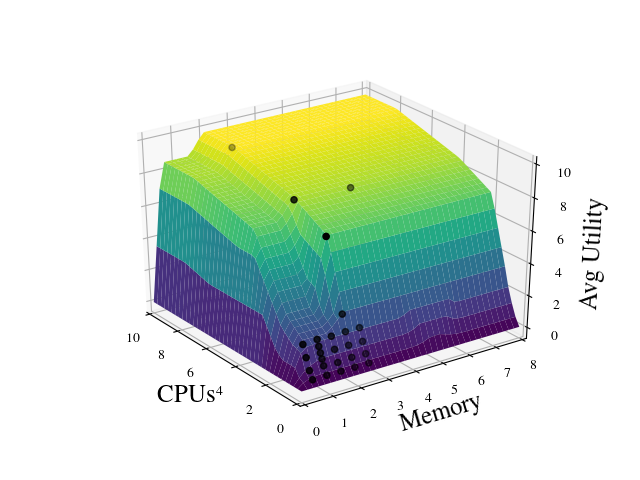

lego Profile
calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


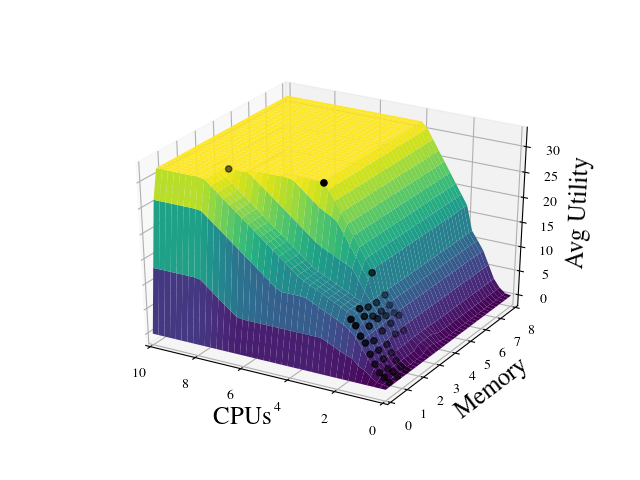

pingpong Profile
calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


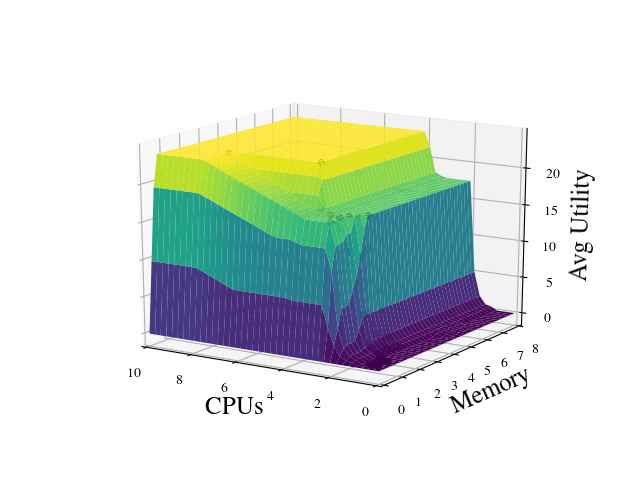

pool Profile
calculating per second util by each_util * avg_fps


<IPython.core.display.Javascript object>


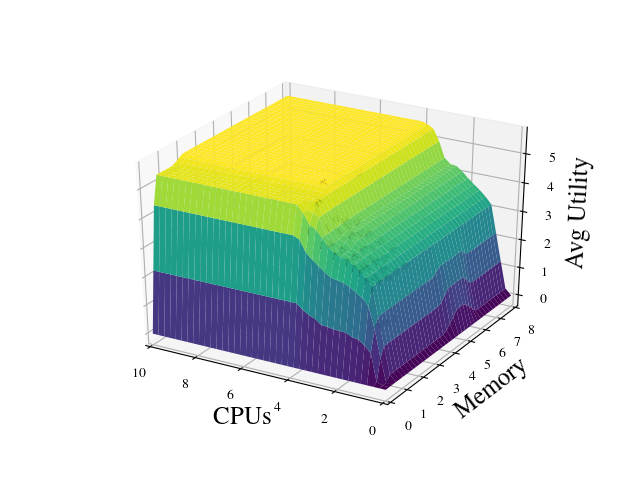

face Profile


In [177]:
# plot application profiles
per_time = False
l2u_funcs = {}
#TODO(junjuew): Edmond why is there a min?
for app in app_default_utility_func:
    l2u_funcs[app] = (lambda lat: min(30, (1000./lat)) * app_default_utility_func[app](lat)) \
                        if per_time else app_default_utility_func[app]
        

exp_name = 'fix-worker'
legop = ResourceToLatency('lego', exp_name, l2u_funcs['lego'])
pingpongp = ResourceToLatency('pingpong', exp_name, l2u_funcs['pingpong'])
poolp = ResourceToLatency('pool', exp_name, l2u_funcs['pool'])
facep = ResourceToLatency('face', exp_name, l2u_funcs['face'])
legop.plot_util()
pingpongp.plot_util()
poolp.plot_util()
facep.plot_util()

In [166]:
print(poolp.func(1.05, np.arange(0, 3, 0.1)))
print(poolp.func(1.05, 0.2))
print(poolp.func(1.05, 0.3))

[0.00000000e+00 4.80808081e-11 9.61616162e-11 1.44242424e-10
 2.15586545e-02 1.07793272e-01 1.07793272e-01 1.07793272e-01
 1.07793272e-01 1.07793272e-01 1.07793272e-01 1.07793272e-01
 1.14899663e-01 1.24374851e-01 1.33850038e-01 1.43325226e-01
 2.20084656e-01 2.96844085e-01 3.73603514e-01 4.31173086e-01
 4.31173086e-01 4.31173086e-01 4.31173086e-01 4.31173086e-01
 4.31173086e-01 4.31173086e-01 4.31173086e-01 4.31173086e-01
 4.31173086e-01 4.31173086e-01]
9.61616162187487e-11
1.4424242432812302e-10


<IPython.core.display.Javascript object>


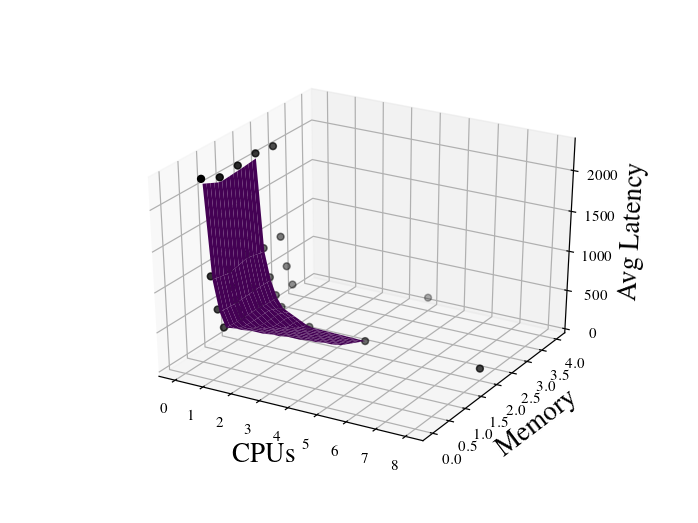

lego Latency


<IPython.core.display.Javascript object>


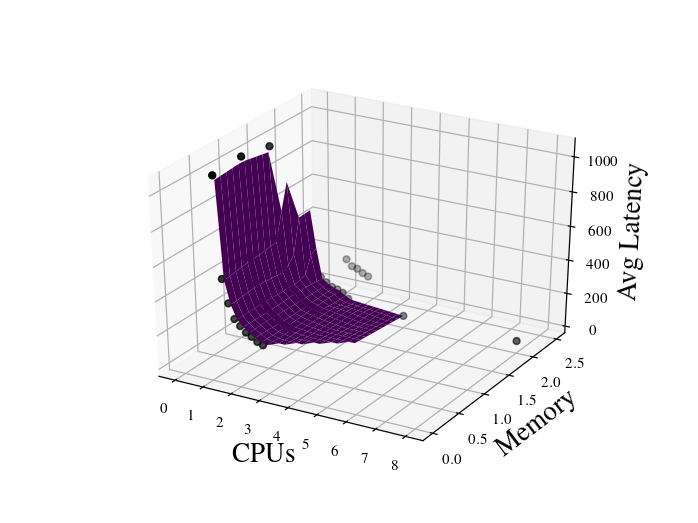

pingpong Latency


<IPython.core.display.Javascript object>


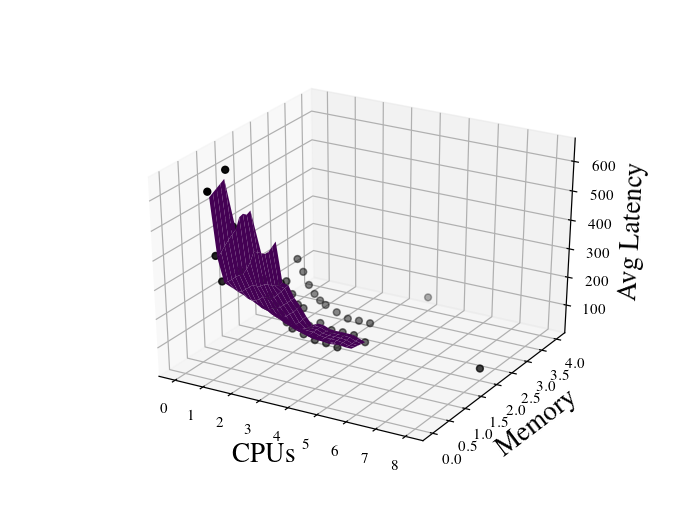

pool Latency


<IPython.core.display.Javascript object>

face Latency


In [25]:
legop.plot_latency()
pingpongp.plot_latency()
poolp.plot_latency()
facep.plot_latency()

legop.save_latency_func()
pingpongp.save_latency_func()
poolp.save_latency_func()
facep.save_latency_func()

<IPython.core.display.Javascript object>


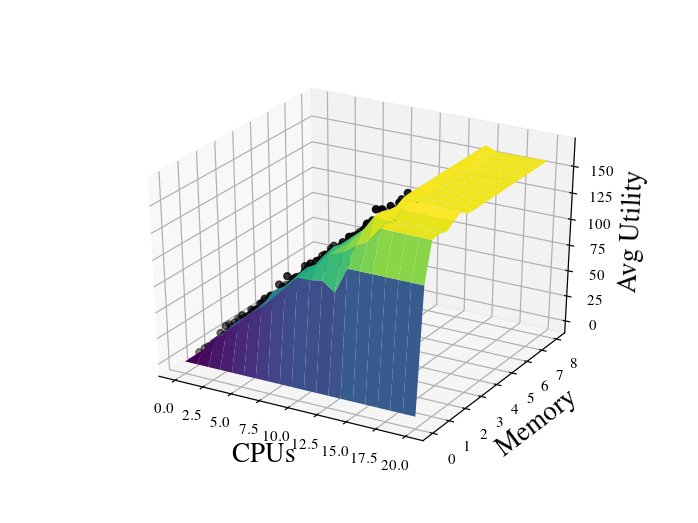

lego Profile


<IPython.core.display.Javascript object>


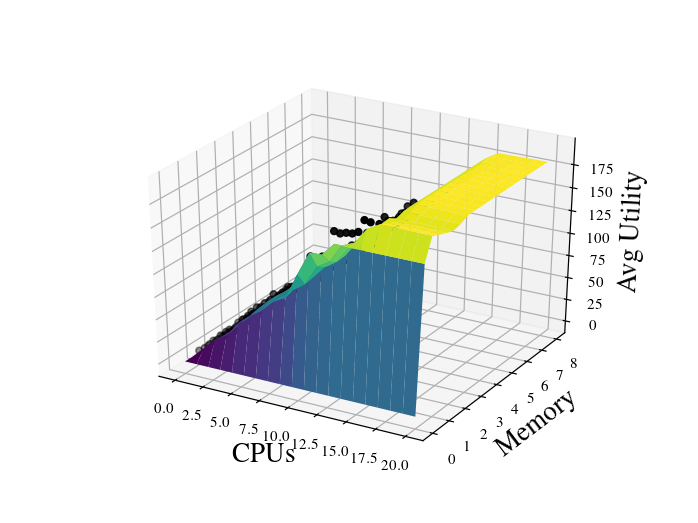

pingpong Profile


<IPython.core.display.Javascript object>


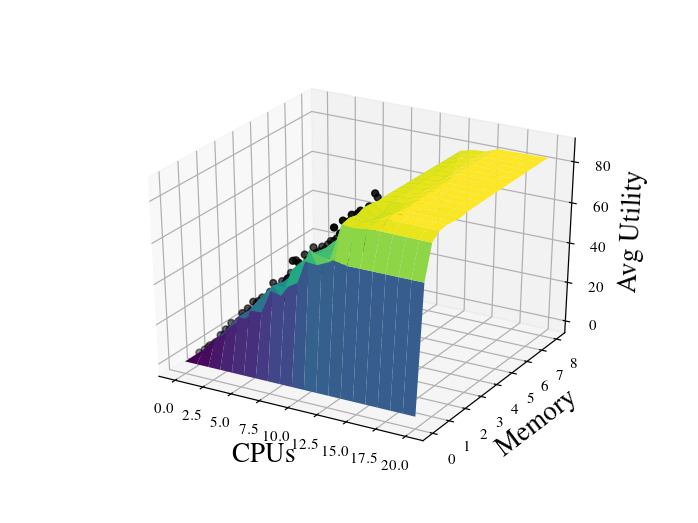

pool Profile


<IPython.core.display.Javascript object>


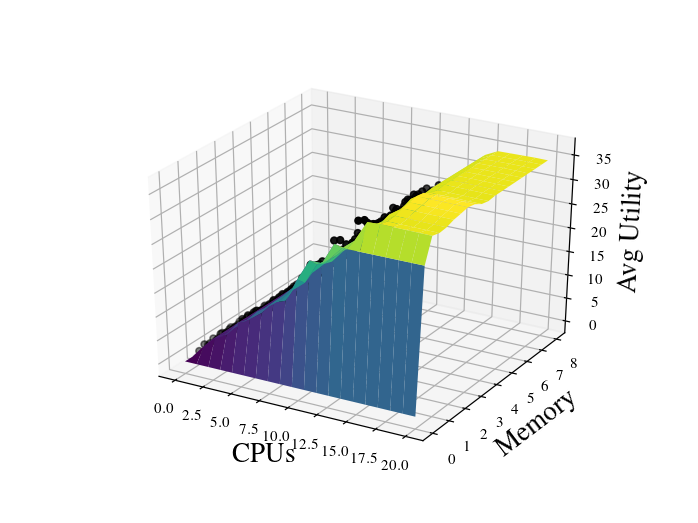

face Profile


In [14]:
# plot application profiles
per_time = True
l2u_funcs = {}
for app in app_default_utility_func:
    l2u_funcs[app] = (lambda lat: min(30, (1000./lat)) * app_default_utility_func[app](lat)) \
                        if per_time else app_default_utility_func[app]
        

exp_name = 'auto-worker'
legop = ResourceToLatency('lego', exp_name, l2u_funcs['lego'])
pingpongp = ResourceToLatency('pingpong', exp_name, l2u_funcs['pingpong'])
poolp = ResourceToLatency('pool', exp_name, l2u_funcs['pool'])
facep = ResourceToLatency('face', exp_name, l2u_funcs['face'])
legop.plot_util()
pingpongp.plot_util()
poolp.plot_util()
facep.plot_util()

In [167]:
# save interpolated func
map(lambda x: x.save_func(), [legop, pingpongp, poolp, facep])

[None, None, None, None]

In [13]:
facep.func(0, 4)

array(0.)

In [ ]:
## iterative random search

In [46]:
legop = ResourceToLatency('lego')
pingpongp = ResourceToLatency('pingpong')
poolp = ResourceToLatency('pool')
poolp.print_profile()

159.78876945 2.3526938731 112.969324963 -2.12329980683
657.504374695 -0.193646495157 31.6264004335 -1.45224465067
227.326144942 2.13587512615 44.3257277065 -2.61532828331
   mean_latency  cpu  memory
0    185.069721    1       2
1     54.591568    2       2
2     42.363702    4       2
3     48.180192    4       4
4     42.570650    8       2


<IPython.core.display.Javascript object>


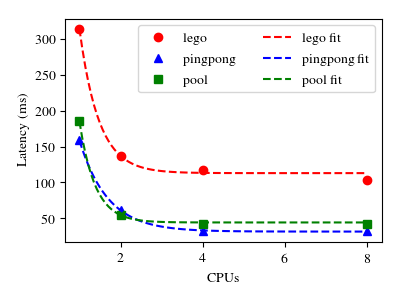

In [50]:
plt.figure(figsize=(4,3))
legop.plot_cpu(plt, fmt='ro')
pingpongp.plot_cpu(plt, fmt='b^')
poolp.plot_cpu(plt, fmt='gs')

# # fit lego
# (a, b, c, d), _ = scipy.optimize.curve_fit(lambda x,a,b,c,d: c*np.exp(-1*(x+a)) +b, legop._df['cpu'].values, legop._df['mean_latency'].values)
# print(a, b, c, d)

x = np.linspace(1, 8, 100)
plt.plot(x, legop(x), 'r--', label='lego fit')
plt.plot(x, pingpongp(x), 'b--', label='pingpong fit')
plt.plot(x, poolp(x), 'g--', label='pool fit')
plt.xlabel('CPUs')
plt.ylabel('Latency (ms)')

plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('fig-res-lat.pdf', bbox_inches='tight')

In [51]:
class ResourceToUtility(object):
    def __init__(self, res_to_lat, lat_to_util):
        self.res_to_lat = res_to_lat
        self.lat_to_util = lat_to_util
        
    def __call__(self, cpu, **kwargs):
        return self.lat_to_util(self.res_to_lat(cpu, **kwargs))

<IPython.core.display.Javascript object>


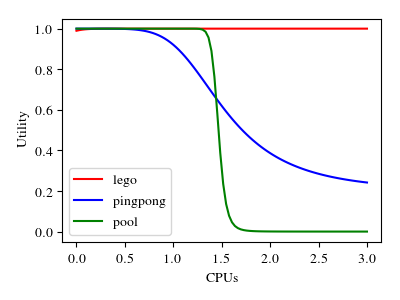

159.78876945 2.3526938731 112.969324963 -2.12329980683
657.504374695 -0.193646495157 31.6264004335 -1.45224465067
227.326144942 2.13587512615 44.3257277065 -2.61532828331


In [52]:
plt.figure(figsize=(4,3))
cpus = np.linspace(0,3,100)
for app, c in [('lego', 'r'), ('pingpong', 'b'), ('pool', 'g')]:
    uf = ResourceToUtility(ResourceToLatency(app),
                           app_default_utility_func[app])
    plt.plot(cpus, uf(cpus), c+'-', label=app)

plt.legend()
plt.xlabel("CPUs")
plt.ylabel("Utility")
plt.tight_layout()
plt.savefig('fig-res-util.pdf', bbox_inches='tight')